# Goal
* Given an MLP, $f$ 
* Show how to calculate $$\frac{df}{dx}$$
* In constrast to calculating 
$$\frac{df_{loss}}{dx}$$
---
If our function is    
$$y = x^2$$    
Then,   

$$
\frac{dy}{dx} = 2x
$$

Then, $$\frac{d^2y}{dx^2} = 2$$

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
def mish(input):
    return input * torch.tanh(F.softplus(input))

class Mish(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, _input):
        return mish(_input)
    
def make_batch(x): return x[:,None]

def debatch(x, detach = True):
    x =  x.squeeze()
    if detach: x = x.detach()
    return x

def make_mlp(n = 20, layers_count = 3, act = Mish):
    layers = []
    layers.append(nn.Linear(1,n))
    layers.append(act())
    for i in range(layers_count -2):
        layers.append(nn.Linear(n,n))
        layers.append(act())
    layers.append(nn.Linear(n,1))
    mlp = nn.Sequential(*layers)
    return mlp

class Stepper:
    clear_grad = True
    def __call__(self,my_mlp,xb, yb, lr = 1e-1):
        yprime = my_mlp(xb)
        loss = F.mse_loss(yb,yprime )
        loss.backward()
        for name, param in my_mlp.named_parameters():
            param.data = param.data - param.grad*lr
        if self.clear_grad: my_mlp.zero_grad()
        self.yprime = yprime
        return yprime.squeeze().detach()

In [4]:
do_step = Stepper()

In [5]:
x = torch.linspace(-1,1, 20)

In [6]:
def my_fun(x):
    y = x**2
    dydx = 2*x
    d2yd2x = x*0+2
    return y, dydx, d2yd2x

In [23]:
y, dydx_analytical, d2yd2x_analytical = my_fun(x)

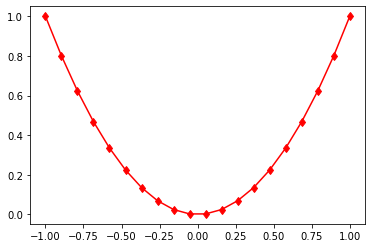

In [8]:
plt.plot(x,y, "rd-")

In [49]:
mlp = make_mlp(act = nn.ReLU)

In [50]:
xb, yb = [make_batch(z) for z in [x,y]]

In [51]:
yprime = mlp(xb)

In [52]:
yprime_debatch = debatch(yprime)

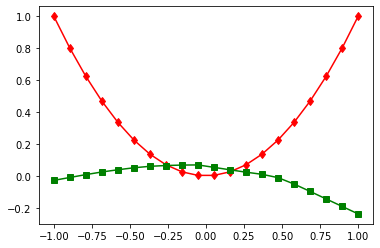

In [53]:
plt.plot(x,y, "rd-", label = "true")
plt.plot(x,yprime_debatch, "gs-", label = "MLP")

In [54]:
for i in range(300):
    yprime_out = do_step(mlp, xb, yb, lr = 1e-1)

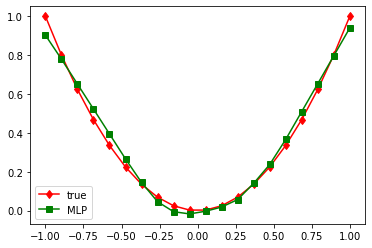

In [55]:
plt.plot(x,y, "rd-", label = "true")
plt.plot(x,yprime_out, "gs-", label = "MLP")
plt.legend()

In [56]:
xb.requires_grad = True
yprime = mlp(xb)

In [57]:
dydx = torch.autograd.grad(yprime.sum(), xb, create_graph=True)[0]

In [58]:
d2yd2x = torch.autograd.grad(dydx.sum(), xb, create_graph=True)[0]

In [59]:
# y, dydx_analytical, d2yd2x_analytical 

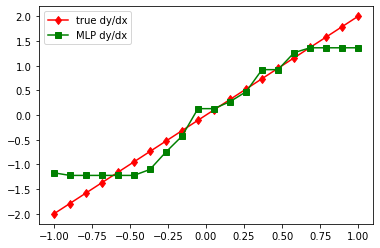

In [60]:
plt.plot(x,dydx_analytical, "rd-", label = "true dy/dx")
plt.plot(x,debatch(dydx), "gs-", label = "MLP dy/dx")
plt.legend()

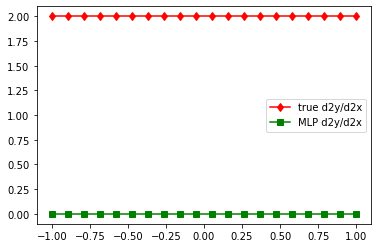

In [61]:
plt.plot(x,d2yd2x_analytical, "rd-", label = "true d2y/d2x")
plt.plot(x,debatch(d2yd2x), "gs-", label = "MLP d2y/d2x")
plt.legend()